In [71]:
# Helper functions
import polytope as pt
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.linalg
from scipy.integrate import solve_ivp
from numpy.linalg import norm
import pyomo.environ as pyo


# # Helper Functions:

def minkowski_sum(X, Y):

    # Minkowski sum between two polytopes based on 
    # vertex enumeration. So, it's not fast for the
    # high dimensional polytopes with lots of vertices.
    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        # assuming vertices are in (N x d) shape. N # of vertices, d dimension
        V1 = X
        it
    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])
    return pt.qhull(np.asarray(V_sum))


def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([]), Wset=pt.Polytope()):
    
    if not B.any():
        if not pt.is_empty(Wset):
            return pt.Polytope( pontryagin_diff(Xset, Wset).A @ A, Xset.b)
        else:
            return pt.Polytope(Xset.A @ A, Xset.b)
        
    if not pt.is_empty(Wset):
        tmp  = minkowski_sum( pontryagin_diff(Xset, Wset), pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)
    else:
        tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)
    
    
    
def Oinf(A, Xset, Wset=pt.Polytope()):
    
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = pt.reduce(precursor(Omega, A, Wset=Wset).intersect(Omega))
        else:
            Omegap = pt.reduce(precursor(Omega, A).intersect(Omega))
    return Omegap


def Cinf(A, B, Xset, Uset):
    
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    return Omegap

def dlqr(A, B, Q, R):
    # solve Discrete Algebraic Riccatti equation  
    P_inf = scipy.linalg.solve_discrete_are(A, B, Q, R)

    # compute the LQR gain
    F_inf = -scipy.linalg.inv(B.T @ P_inf @ B + R) @ (B.T @ P_inf @ A)

    # stability check 
    eigVals, eigVecs = scipy.linalg.eig(A + B @ F_inf)
    return F_inf, P_inf, eigVals

# differential equation of the ball
def ball_ode(t, x):
    # x = [x_b, y_b, vx_b, vy_b]
    return np.array([x[2], x[3], 0, -g])


# event that detects the ball impact
def ball_bounce(t, x):
    return x[1]
    
ball_bounce.terminal = True
ball_bounce.direction = -1

In [78]:
def calc_eq(xd):
    x_eq = xd
#   TODO:  someone check math with matlab on u_eq1: set v_by_pre = v_by_post @ equilibrium point
    u_eq1 = ((1 - e)*np.sqrt(2*g*x_eq[2]))/(e + 1)
    u_eq = np.array([u_eq1, 0])
    
    return x_eq, u_eq
    
def linearize(x_eq, u_eq):
    A11 = 1
    A12 = ((2*e*np.sin(u_eq[1])**2 + 2*np.sin(u_eq[1])**2 - 2)*
           (u_eq[0]*(np.sin(u_eq[1])**2 - 1)*(e + 1) - x_eq[1]*np.sin(2*u_eq[1])*(e/2 + 1/2) + np.sqrt(2*g*x_eq[2])*(
            e*np.sin(u_eq[1])**2 - e + np.sin(u_eq[1])**2)))/g - (np.sin(2*u_eq[1])*(e/2 + 1/2)*(
            2*x_eq[1]*(e*np.sin(u_eq[1])**2 + np.sin(u_eq[1])**2 - 1) + u_eq[0]*np.sin(2*u_eq[1])*(e + 1) + 2*np.sqrt(2
            )*np.sin(2*u_eq[1])*(e/2 + 1/2)*np.sqrt(g*x_eq[2])))/g
    A13 = (np.sqrt(2)*(e*np.sin(u_eq[1])**2 - e + np.sin(u_eq[1])**2)*(
           2*x_eq[1]*(e*np.sin(u_eq[1])**2 + np.sin(u_eq[1])**2 - 1) + u_eq[0]*np.sin(2*u_eq[1])*(e + 1) + 2*np.sqrt(
           2)*np.sin(2*u_eq[1])*(e/2 + 1/2)*np.sqrt(g*x_eq[2])))/(2*np.sqrt(g*x_eq[2])) + (
           np.sqrt(2)*np.sin(2*u_eq[1])*(e/2 + 1/2)*(u_eq[0]*(np.sin(u_eq[1])**2 - 1)*(e + 1) - x_eq[1]*np.sin(2*u_eq[1])*(
           e/2 + 1/2) + np.sqrt(2*g*x_eq[2])*(e*np.sin(u_eq[1])**2 - e + np.sin(u_eq[1])**2)))/np.sqrt(g*x_eq[2])
    A21 = 0
    A22 = 1 - np.sin(u_eq[1])**2 - e*np.sin(u_eq[1])**2
    A23 = -(np.sqrt(2)*g*np.sin(2*u_eq[1])*(e/2 + 1/2))/(2*np.sqrt(g*x_eq[2]))
    A31 = 0
    A32 = -(np.sin(2*u_eq[1])*(e + 1)*(2*u_eq[0]*(np.sin(u_eq[1])**2 - 1)*(e + 1) + 2*np.sqrt(2*g*x_eq[2])*(e*np.sin(u_eq[1])**2 - e + np.sin(
            u_eq[1])**2) - x_eq[1]*np.sin(2*u_eq[1])*(e + 1)))/(4*g)
    A33 = (np.sqrt(2)*(2*u_eq[0]*(np.sin(u_eq[1])**2 - 1)*(e + 1) + 2*np.sqrt(2*g*x_eq[2])*(e*np.sin(
           u_eq[1])**2 - e + np.sin(u_eq[1])**2) - x_eq[1]*np.sin(2*u_eq[1])*(e + 1))*(
           e*np.sin(u_eq[1])**2 - e + np.sin(u_eq[1])**2))/(4*np.sqrt(g*x_eq[2]))
    A = np.array([[A11, A12, A13],
                  [A21, A22, A23],
                  [A31, A32, A33]])

    B11 = ((np.sin(u_eq[1])**2 - 1)*(e + 1)*(2*x_eq[1]*(e*np.sin(u_eq[1])**2 + np.sin(
           u_eq[1])**2 - 1) + u_eq[0]*np.sin(2*u_eq[1])*(e + 1) + 2*np.sqrt(2)*np.sin(2*u_eq[1])*(
           e/2 + 1/2)*np.sqrt(g*x_eq[2])))/g + (np.sin(2*u_eq[1])*(e + 1)*(
           u_eq[0]*(np.sin(u_eq[1])**2 - 1)*(e + 1) - x_eq[1]*np.sin(2*u_eq[1])*(e/2 + 1/2) + np.sqrt(2*g*x_eq[2])*(
           e*np.sin(u_eq[1])**2 - e + np.sin(u_eq[1])**2)))/g
    B12 = ((np.sqrt(2)*(2*np.cos(u_eq[1])*np.sin(u_eq[1]) + 2*e*np.cos(u_eq[1])*np.sin(u_eq[1]))*np.sqrt(
           g*x_eq[2]) - 2*x_eq[1]*np.cos(2*u_eq[1])*(e/2 + 1/2) + 2*u_eq[0]*np.cos(u_eq[1])*np.sin(u_eq[1])*(e + 1))*(
           2*x_eq[1]*(e*np.sin(u_eq[1])**2 + np.sin(u_eq[1])**2 - 1) + u_eq[0]*np.sin(2*u_eq[1])*(e + 1) + 2*np.sqrt(2)*np.sin(
           2*u_eq[1])*(e/2 + 1/2)*np.sqrt(g*x_eq[2])))/g + ((u_eq[0]*(np.sin(u_eq[1])**2 - 1)*(e + 1) - x_eq[1]*np.sin(2*u_eq[1])*(
           e/2 + 1/2) + np.sqrt(2*g*x_eq[2])*(e*np.sin(u_eq[1])**2 - e + np.sin(u_eq[1])**2))*(2*x_eq[1]*(2*np.cos(u_eq[1])*np.sin(
           u_eq[1]) + 2*e*np.cos(u_eq[1])*np.sin(u_eq[1])) + 2*u_eq[0]*np.cos(2*u_eq[1])*(e + 1) + 4*np.sqrt(2)*np.cos(2*u_eq[1])*(
           e/2 + 1/2)*np.sqrt(g*x_eq[2])))/g
    B21 = -np.sin(2*u_eq[1])*(e/2 + 1/2)
    B22 = -x_eq[1]*(2*np.cos(u_eq[1])*np.sin(u_eq[1]) + 2*e*np.cos(u_eq[1])*np.sin(u_eq[1])) - 2*u_eq[0]*np.cos(
          2*u_eq[1])*(e/2 + 1/2) - 2*np.sqrt(2)*np.cos(2*u_eq[1])*(e/2 + 1/2)*np.sqrt(g*x_eq[2])
    B31 = ((np.sin(u_eq[1])**2 - 1)*(e + 1)*(2*u_eq[0]*(np.sin(u_eq[1])**2 - 1)*(e + 1) + 2*np.sqrt(2*g*x_eq[2])*(
           e*np.sin(u_eq[1])**2 - e + np.sin(u_eq[1])**2) - x_eq[1]*np.sin(2*u_eq[1])*(e + 1)))/(2*g)
    B32 = ((2*u_eq[0]*(np.sin(u_eq[1])**2 - 1)*(e + 1) + 2*np.sqrt(2*g*x_eq[2])*(e*np.sin(u_eq[1])**2 - e + np.sin(
           u_eq[1])**2) - x_eq[1]*np.sin(2*u_eq[1])*(e + 1))*(2*np.sqrt(2)*(2*np.cos(u_eq[1])*np.sin(u_eq[1]) + 2*e*np.cos(
           u_eq[1])*np.sin(u_eq[1]))*np.sqrt(g*x_eq[2]) - 2*x_eq[1]*np.cos(2*u_eq[1])*(e + 1) + 4*u_eq[0]*np.cos(u_eq[1])*np.sin(u_eq[1])*(e + 1)))/(4*g)
    B = np.array([[B11, B12],
                  [B21, B22],
                  [B31, B32]])
    return A, B

def terminal_cons(A, B, Q, R, X, U):
    F_inf, P_inf, eig_vals = dlqr(A, B, Q, R)
    A_cl = A+ B@F_inf
    S = X.intersect(pt.Polytope(U.A @ F_inf, U.b))
    O_inf = Oinf(A_cl, S)
    Af = O_inf.A
    bf = O_inf.b
    
    # # Finding Controllable Invariant Set
    C_inf = Cinf(A_cl, B, X, U)
    X0_C = {}
    PreS = precursor(O_inf, A, U, B)
    for j in range(N):
        X0_C[j] = PreS.intersect(X)
        PreS = precursor(X0_C[j], A, U, B)

    # # Finding X0 set
    X0 = X0_C[N-1]
    return Af, bf

### Inputs:
* u[0] = y velocity of paddle
* u[1] = angle of the paddel

### States:
* x[0] = x position at impact
* x[1] = x velocity of the ball before impact
* x[2] = initial height

In [67]:
# modify to accept A and B
def solve_cftoc(A, B, P, Q, R, N, x0, xB, uB, x_eq, u_eq, bf=0, Af=[]):
    
    model = pyo.ConcreteModel()
    model.N = N
    model.nx = x0.shape[0]
    model.nu = nu
    model.nf = np.size(Af, 0)

    # length of finite optimization problem:
    model.tidx = pyo.Set(initialize=range(N+1), ordered=True) # length of finite optimization problem
    model.xidx = pyo.Set(initialize=range(model.nx), ordered=True)
    model.uidx = pyo.Set(initialize=range(model.nu), ordered=True)
    model.nfidx = pyo.Set(initialize=range(model.nf), ordered=True)

    # create state and input trajectory:
    model.x = pyo.Var(model.xidx, model.tidx)
    model.u = pyo.Var(model.uidx, model.tidx) # u[0] = y velocity of paddel u[1] = angle of the paddle

    # this variable holds the velocity of the ball before and after impact
    model.vby_pre = pyo.Var(model.tidx)
    model.vb_post = pyo.Var(model.uidx, model.tidx)
    
    # 2d Arrays
    model.Q = Q
    model.P = P
    model.R = R
    model.A = A
    model.B = B
    model.Af = Af
    model.bf = bf

    def objective_rule(model):
        costX = 0.0
        costU = 0.0
        costTerminal = 0.0
        for t in model.tidx:
            for i in model.xidx:
                for j in model.xidx:
                    if t < model.N:
                        costX += (model.x[i, t]-x_eq[i]) * model.Q[i, j] * (model.x[j, t]-x_eq[j])
        for t in model.tidx:
            for i in model.uidx:
                for j in model.uidx:
                    if t < model.N:
                        costU += (model.u[i, t]-u_eq[i]) * model.R[i, j] * (model.u[j, t]-u_eq[i])
        for i in model.xidx:
            for j in model.xidx:
                costTerminal += (model.x[i, model.N]-x_eq[i]) * model.P[i,j] * (model.x[j, model.N]-x_eq[j])
        return costX + costU + costTerminal
    
    model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)

    # initial impact constraint
    model.init_cons = pyo.Constraint(model.xidx, rule=lambda model, i: model.x[i, 0] == x0[i])
    
    # calculating pre impact velocity y-direction:
    model.vby_pre_calc = pyo.Constraint(model.tidx, rule=lambda model, i: model.vby_pre[i] == -np.sqrt(2*g*x0[2]) if i == 0 else model.vby_pre[i] == -model.vb_post[1, i-1])

    # calculating the post impact velocity
    model.vb1_post_calc = pyo.Constraint(model.tidx, rule=lambda model, i: model.vb_post[0,i] == model.vby_pre[i]*(pyo.cos(model.u[1,i])*pyo.sin(model.u[1,i])
                                           + e*pyo.cos(model.u[1,i])*pyo.sin(model.u[1,i])) - model.x[1,i]*(e*(pyo.sin(model.u[1,i])**2) - pyo.cos(model.u[1,i])**2)
                                           - model.u[0,i]*(pyo.cos(model.u[1,i])*pyo.sin(model.u[1,i]) + e*pyo.cos(model.u[1,i])*pyo.sin(model.u[1,i])))
    model.vb2_post_calc = pyo.Constraint(model.tidx, rule=lambda model, i: model.vb_post[1,i] == model.vby_pre[i]*(pyo.sin(model.u[1,i])**2 - e*(pyo.cos(model.u[1,i])**2))
                                           + model.u[0,i]*(e*(pyo.cos(model.u[1,i])**2) - pyo.sin(model.u[1,i])**2 + 1)
                                           + model.x[1,0]*(pyo.cos(model.u[1,i])*pyo.sin(model.u[1,i]) + e*pyo.cos(model.u[1,i])*pyo.sin(model.u[1,i])))
    
    def equality_const_rule(model, i, t):
        return model.x[i, t+1] - (sum(model.A[i, j] * model.x[j, t] for j in model.xidx)
                               +  sum(model.B[i, j] * model.u[j, t] for j in model.uidx) ) == 0.0 if t < model.N else pyo.Constraint.Skip

    model.equality_constraints = pyo.Constraint(model.xidx, model.tidx, rule=equality_const_rule)
    
    # State Constraints
    model.state1_cons = pyo.Constraint(model.tidx, rule=lambda model, t: pyo.inequality(-abs(xB[0]), model.x[0, t], abs(xB[0]))
                                             if t <= N else pyo.Constraint.Skip)
    model.state2_cons = pyo.Constraint(model.tidx, rule=lambda model, t: pyo.inequality(-abs(xB[1]), model.x[1, t], abs(xB[1]))
                                             if t <= N else pyo.Constraint.Skip)
    model.state3_cons = pyo.Constraint(model.tidx, rule=lambda model, t: pyo.inequality(-abs(xB[2]), model.x[2, t], abs(xB[2]))
                                             if t <= N else pyo.Constraint.Skip)
    
    # Input Constraints
    model.input1_cons = pyo.Constraint(model.tidx, rule=lambda model, t: pyo.inequality(-abs(uB[0]), model.u[0, t], abs(uB[0])) if t <= N-1 else pyo.Constraint.Skip)
    model.input2_cons = pyo.Constraint(model.tidx, rule=lambda model, t: pyo.inequality(-abs(uB[1]), model.u[1, t], abs(uB[1])) if t <= N-1 else pyo.Constraint.Skip)
    
    # Terminal Constraint
    if len(Af) == 0:
        model.final_const = pyo.Constraint(model.xidx, rule=lambda model, i: pyo.inequality(-0.001, model.x[i, model.N] - xd[i], 0.001))
    else:
        def final_const_rule(model, i):
            return sum(model.Af[i, j] * model.x[j, model.N] for j in model.xidx) <= model.bf[i]
        
        model.final_const = pyo.Constraint(model.nfidx, rule=final_const_rule)

    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)

    if str(results.solver.termination_condition) == "optimal":
        feas = True
    else:
        feas = False
        
    xOpt = np.asarray([[model.x[i, t]() for i in model.xidx] for t in model.tidx]).T
    uOpt = np.asarray([[model.u[i, t]() for i in model.uidx] for t in model.tidx]).T
    y_vel = np.asarray([model.vby_pre_calc[t]() for t in model.tidx]).T
    
    JOpt = model.cost()
    
    return [model, feas, xOpt, uOpt, JOpt, y_vel]

In [76]:
# Initial Parameter set up
N = 10
g = 9.81 # gravitational acceleration, g/s^2
m = 2.7/1000 # ball mass, kg
e = 0.9 # coeff of restitution
nx = 3
nu = 2
# desired height
yd = 10
# x0 = [x position ball at impact, x velocity of the ball before impact, inital height]
x0 = np.array([1, 1, 30])

Q = np.eye(nx)
R = np.eye(nu)
P = Q

# state upper bounds
xB = np.array([5, 2, 33])

# input upper bounds
uB = np.array([5, 3.14/2])

# constraint set represented as poolyhedra
X = pt.Polytope(np.array([[1.0, 0, 0],
                          [0, 1.0, 0],
                          [0, 0, 1.0],
                          [-1.0, 0, 0],
                          [0, -1.0, 0],
                          [0, 0, -1.0]]),
                np.array([[xB[0]],
                          [xB[1]],
                          [xB[2]],
                          [xB[0]],
                          [xB[1]],
                          [xB[2]]])) 

U = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1.0, 0],
                          [0, -1.0]]),
                np.array([[uB[0]],
                          [uB[1]],
                          [uB[0]],
                          [uB[1]]]))




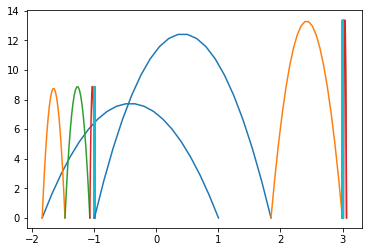

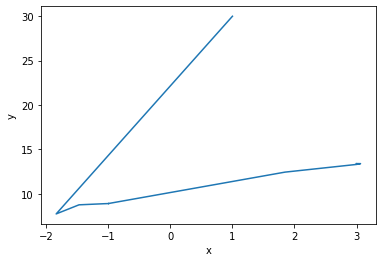

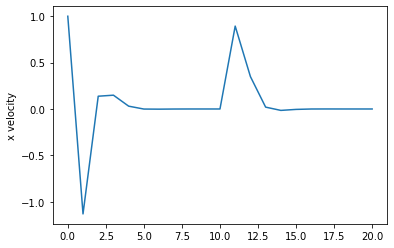

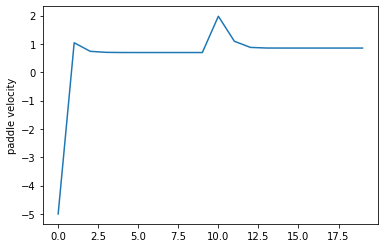

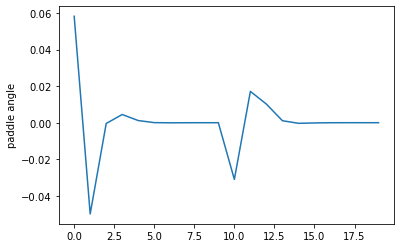

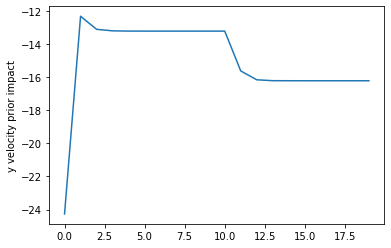

In [79]:
M = 20 # simulation time

# initalize arrays
xOpt = np.zeros((nx, M+1))
uOpt = np.zeros((nu, M))
xd_set = np.zeros((nx, M+1))

for i in range(M + 1):
    if i < 10:
        xd_set[:,i] = np.array([-1, 0, 10])
    else:
        xd_set[:,i] = np.array([3, 0, 15])

xOpt[:, 0] = x0.reshape(nx, )
y_vel_prior = []
feas = np.zeros((M, ), dtype=bool)
A_impact = np.array([[1, 0], [0, -e]])
plt.figure()
for t in range(M):
    xd = xd_set[:, t]
    x_eq, u_eq = calc_eq(xd)
    A, B = linearize(x_eq, u_eq)
    Af, bf = terminal_cons(A, B, Q, R, X, U)
    
    [model, feas[t], x, u, J, y_vel] = solve_cftoc(A, B, P_inf, Q, R, N, xOpt[:, t], xB, uB, x_eq, u_eq, bf, Af)
    if not feas[t]:
        xOpt = []
        uOpt = []
        break
    uk = u[:, 0].reshape(nu, )
    
    R_rot = np.array([[np.cos(uk[1]), -np.sin(uk[1])], [np.sin(uk[1]), np.cos(uk[1])]])
    A_bar = R_rot@A_impact@R_rot.T
    vp = np.array([0, uk[0]])
    xk = xOpt[:,t]
    vb = np.array([xk[1], y_vel[0]])
    vb_post = (np.eye(2) - A_bar)@vp + A_bar@vb
    z0 = np.array([xk[0], 0, vb_post[0], vb_post[1]])
    sol = solve_ivp(ball_ode, (0, 100), z0, events=ball_bounce, dense_output=True)
    sim_t = np.linspace(0, sol.t_events[0][0], 20)
    z = sol.sol(sim_t)
    plt.plot(z[0], z[1])
    zf = z[:,-1]
    xOpt[:, t+1] = np.array([zf[0], zf[2], (0.5*zf[3]**2)/g])
    uOpt[:, t] = uk
   
    y_vel_prior.append(y_vel[0])
    
plt.show()
plt.figure()
plt.plot(xOpt[0, :], xOpt[2, :])
plt.xlabel('x')
plt.ylabel('y')
plt.figure()
plt.plot(xOpt[1, :])
plt.ylabel('x velocity')
plt.figure()
plt.plot(uOpt[0, :])
plt.ylabel('paddle velocity')
plt.figure()
plt.plot(uOpt[1, :])
plt.ylabel('paddle angle')
plt.figure()
plt.plot(y_vel_prior)
plt.ylabel('y velocity prior impact')
plt.show()




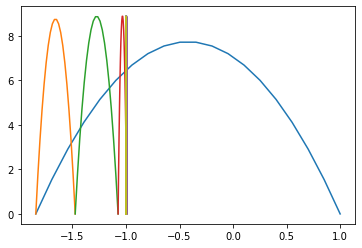

In [80]:
x_full = []

# calculate the new velocity after initial impact
A = np.array([[1, 0], [0, -e]])
R = np.array([[np.cos(uOpt[1,0]), -np.sin(uOpt[1,0])], [np.sin(uOpt[1,0]), np.cos(uOpt[1,0])]])
A_bar = R@A@R.T

vp = np.array([0, uOpt[0, 0]])
vb_0 = [x0[1], -np.sqrt(2*g*x0[2])]
vb_0_post = (np.eye(2) - A_bar)@vp + A_bar@vb_0
z0 = np.array([x0[0], 0, vb_0_post[0], vb_0_post[1]])
plt.figure()

for i in range(N-1):
#   ode simulation of ball projectile motion
    sol = solve_ivp(ball_ode, (0, 100), z0, events=ball_bounce, dense_output=True)
    t = np.linspace(0, sol.t_events[0][0], 20)
    x = sol.sol(t)
    plt.plot(x[0], x[1])
    z0 = x[:,-1]
    R = np.array([[np.cos(uOpt[1,i+1]), -np.sin(uOpt[1,i+1])], [np.sin(uOpt[1,i+1]), np.cos(uOpt[1,i+1])]])
    A_bar = R@A@R.T
    vp = np.array([0, uOpt[0, i + 1]])
    vb_post = (np.eye(2) - A_bar)@vp + A_bar@z0[2:4]
    z0[2] = vb_post[0]
    z0[3] = vb_post[1]
    
plt.show()

